In [1]:
import huggingface_hub
import datasets
import os

HUGGINGFACE_TOKEN = os.environ.get("HUGGINGFACE_TOKEN")

huggingface_hub.login(HUGGINGFACE_TOKEN)

In [2]:
dataset = datasets.load_dataset("kahua-ml/flattened_nameplate_dataset", split="train")

# Model Loading

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

chat_template.json: 0.00B [00:00, ?B/s]

["The image depicts a serene beach scene during what appears to be either sunrise or sunset, as indicated by the warm, golden light illuminating the sky and casting long shadows on the sand. A woman is sitting on the beach, wearing a plaid shirt and dark pants, with her legs crossed. She has long hair and is smiling warmly at a light-colored dog, possibly a Labrador Retriever, which is sitting in front of her. The dog is wearing a harness and is extending its paw towards the woman's hand, suggesting a playful interaction. The ocean is visible in the background, with gentle waves rolling onto the shore. The overall"]


In [13]:
def inference(img, text):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": img,
                },
                {"type": "text", "text": text},
            ],
        }
    ]
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return(output_text[0])


In [7]:
def text_formatter(field):
    text = f"You are a helpful assistant that extracts text from images and returns JSON for programmatic use. Find the value of {field} and return a JSON string in the format of {{'{field}': '<value>'}}."
    return text

In [20]:
import random

ix = random.randint(0, len(dataset))

arr = inference(dataset[ix]["image"], text_formatter(dataset[ix]["field"]))

In [ ]:
arr

'```json\n{\n  "serial_number": "S/N.14-11-14-87187A"\n}\n```'

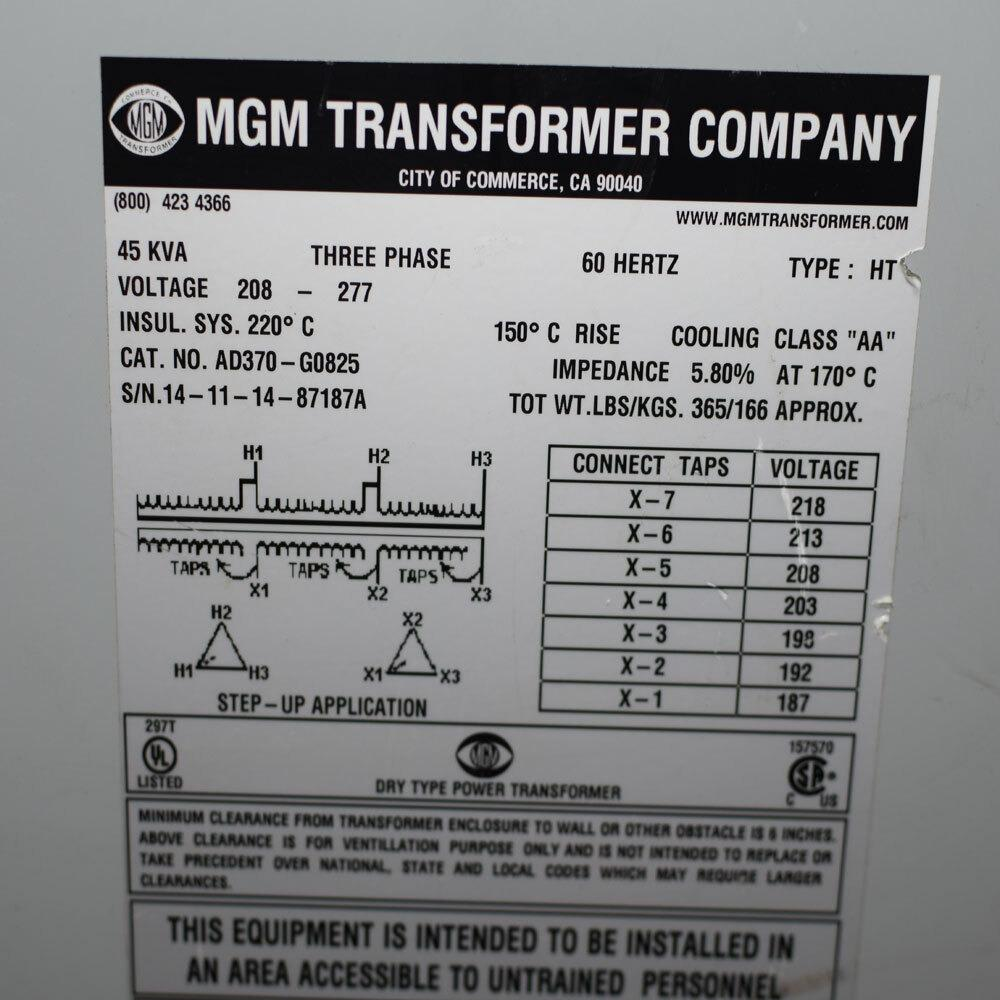

In [22]:
dataset[ix]["image"]

Loading Peft

In [26]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=64,  # Larger rank is often better for large models
    lora_alpha=128,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # Specific to Qwen's attention/FFN
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model.enable_input_require_grads()  # Required for LoRA
peft_model = get_peft_model(model, peft_config)

Dataset Split

In [28]:
# Perform an 80-20 random split
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Assign to separate variables
train_ds = split_dataset["train"]
test_ds = split_dataset["test"]

train_ds = train_ds.shuffle()
test_ds = test_ds.shuffle()

In [32]:
from typing import Any
from unittest.util import _MAX_LENGTH
import torch
from qwen_vl_utils import process_vision_info


class MyDataCollator:
    def __init__(self, processor) -> None:
        self.processor = processor
       
    def __call__(self, examples) -> Any:
        texts = []
        images = []
        assistant_responses = []

        for example in examples:
            image = example["image"]
            field = example["field"]
            answer = example["value"]
           
            messages = [
                {
                    "role": "user",
                    "content": [
                        # If you want EXACT order as inference, put image first
                        {"type": "image", "image": image},
                        {"type": "text", "text": text_formatter(field)},
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
           
            # Make sure to unify arguments with inference
            text = self.processor.apply_chat_template(
                messages, 
                tokenize=False,                 # match inference
                add_generation_prompt=True       # match inference
            )
            texts.append(text)
            images += process_vision_info(messages)[0]
            assistant_responses.append(answer)
       
        batch = self.processor(
            text=texts,
            images=images,
            return_tensors='pt',
            padding=True,
        )

        labels = batch["input_ids"].clone()
       
        for i, (input_ids, assistant_response) in enumerate(zip(batch["input_ids"], assistant_responses)):
            assistant_tokens = self.processor.tokenizer(
                assistant_response, return_tensors="pt"
            )["input_ids"][0]
            
            start_idx = self.find_subsequence(input_ids, assistant_tokens)
            if start_idx is not None:
                labels[i, :start_idx] = -100
                labels[i, start_idx + len(assistant_tokens):] = -100

        batch["labels"] = labels
        return batch

    def find_subsequence(self, sequence, subsequence):
        seq_len = len(sequence)
        sub_len = len(subsequence)
       
        for i in range(seq_len - sub_len + 1):
            if torch.equal(sequence[i : i + sub_len], subsequence):
                return i
        return None
   
data_collator = MyDataCollator(processor)  

In [33]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    num_train_epochs=1,  # You can go longer, but monitor for overfitting
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,  # Helps simulate larger batch size
    learning_rate=1e-4,  # Smaller LR for larger models
    warmup_ratio=0.03,
    logging_steps=80,
    eval_strategy="steps",
    eval_steps=80,
    save_strategy="steps",
    save_steps=80,
    save_total_limit=2,
    gradient_checkpointing=True,
    bf16=True,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    remove_unused_columns=False,
    output_dir="./qwen-peft-vl",
    report_to="none",  # Avoid external logging unless needed
)


trainer = Trainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    eval_dataset=test_ds,
    train_dataset=train_ds,
)

In [34]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss


KeyboardInterrupt: 